# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-coreset'
epochs = 10
batch_size = 8
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctor-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def coreset_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = [0]  # Start with an arbitrary first sample (e.g., index 0)
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices].min(axis=0)
        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(selected_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6763, Accuracy: 0.9137, F1 Micro: 0.937, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5135, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3077, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2448, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2255, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1898, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1761,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5935, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3647, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2101, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2026, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1941, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1926, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1812,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5247, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1878, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2012, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1532, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1358, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4857, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1543, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1464, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1579, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4442, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1613, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1265, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1417, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1161,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2139, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1463, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1451, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1275, Accuracy: 0.9688, F1 Micro: 0.976

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4018, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2016, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1599, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1332, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.135, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1195, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4052, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1982, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1352, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1275, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1224

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2011, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7229
Epoch 8/10, Train Loss: 0.1155, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7387
Epoch 9/10, Train Loss: 0.0892, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7387
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1965, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1522, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.134, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.1328, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0946, Accuracy: 0.9777, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2067, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1641, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1573, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1214, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.1132, Accuracy: 0.9688, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.202, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2005, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1397, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.9702, F1 Micro: 0.9772

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3524, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1297, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7457
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2021, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1573, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1338, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1154, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.09, Accuracy: 0.9628, F1 Micro: 0.9712

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3395, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7541
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7779
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3433, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1962, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9732, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.334, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9732, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3228, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7976
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0555, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3187, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1759, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7402
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7402
Epoch 10/10, Train Loss: 0.0664, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3299, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1823, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7569
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.318, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1628, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7466
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7827
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3196, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7402
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0499, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1294, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9628, F1 Micro: 0.9715, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7809
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7595
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3055, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1656, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1546, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7521
Epoch 10

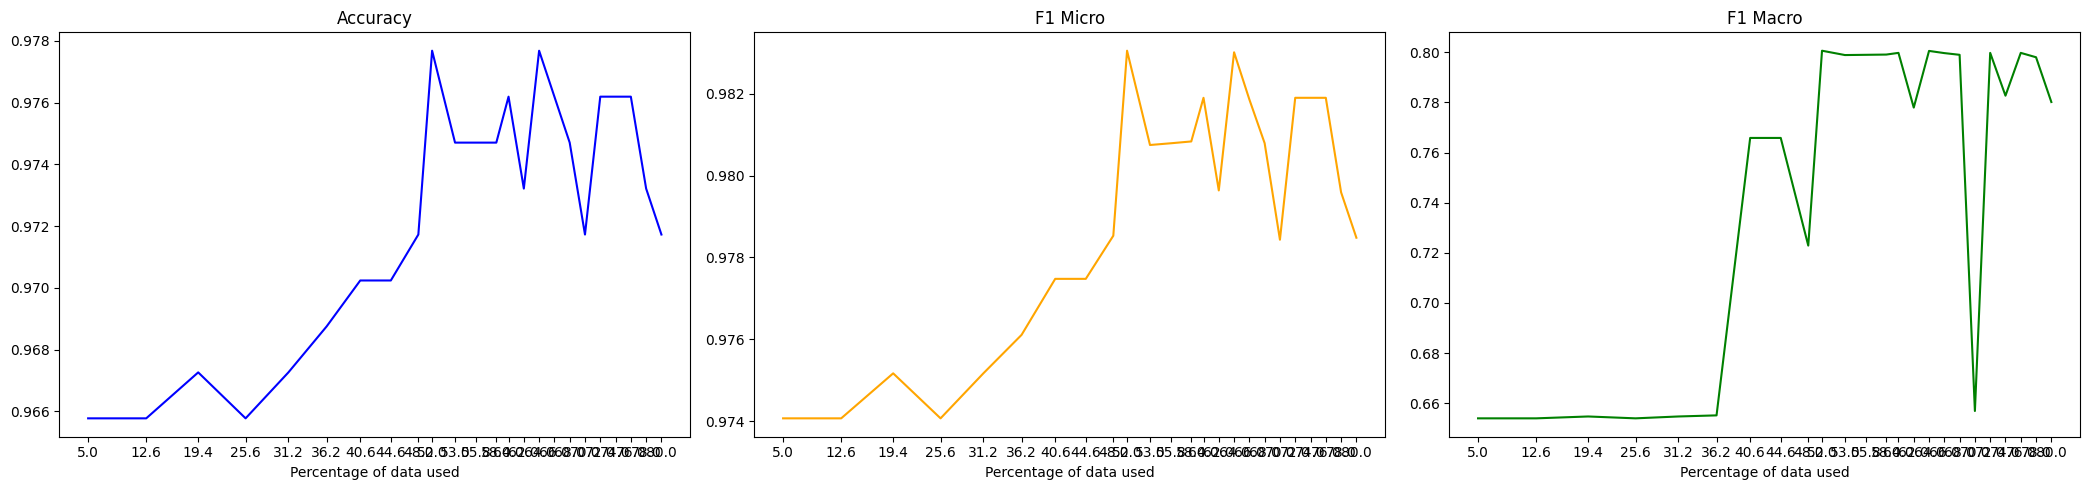

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7235, Accuracy: 0.9062, F1 Micro: 0.9317, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5261, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4066, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3144, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2063,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6409, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3804, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2338, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2318, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.186, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1482, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1832, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1531, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5346, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2085, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1946, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1358, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1311, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4989, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2246, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1577, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1804, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1423, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.137, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4524, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1934, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1449, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 9/10, Train Loss: 0.1265, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4149, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1336, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1346, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1229, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4098, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2311, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1592, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1739, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1331, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1086,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1612, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.158, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1208, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.112, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.381, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2068, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1717, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1598, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1372, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 8/10, Train Loss: 0.1164, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0944, Accuracy: 0.9717, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3658, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1543, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 8/10, Train Loss: 0.1082, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.1102, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7622
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3501, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1667, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1539, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1269, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1224, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1018

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3489, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1436, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1219, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7983
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1053, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9747, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3366, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7622
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7771
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3531, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1316, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7645
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7633
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7952
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2034, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7229
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.7967
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.317, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1621, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1221, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7394
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7659
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1826, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7671
Epoch 10/10, Train Loss: 0.051, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3152, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1841, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.7622
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7887
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3282, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9762, F1 Micro: 0.9818, F1 Macro: 0.7995
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.796
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.324, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.192, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9628, F1 Micro: 0.9712, F1 Macro: 0.7909
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3074, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7227
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7939
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9702, F1 Micro: 0.9771, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7988
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3219, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7977
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9747, F1 Micro: 0.9806, F1 Macro: 0.7986
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7884
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3138, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1693, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9747, F1 Micro: 0.9806, F1 Macro: 0.7986
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8235
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3105, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.166, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1348, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.78
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9598, F1 Micro: 0.9693, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9792, F1 Micro: 0.9

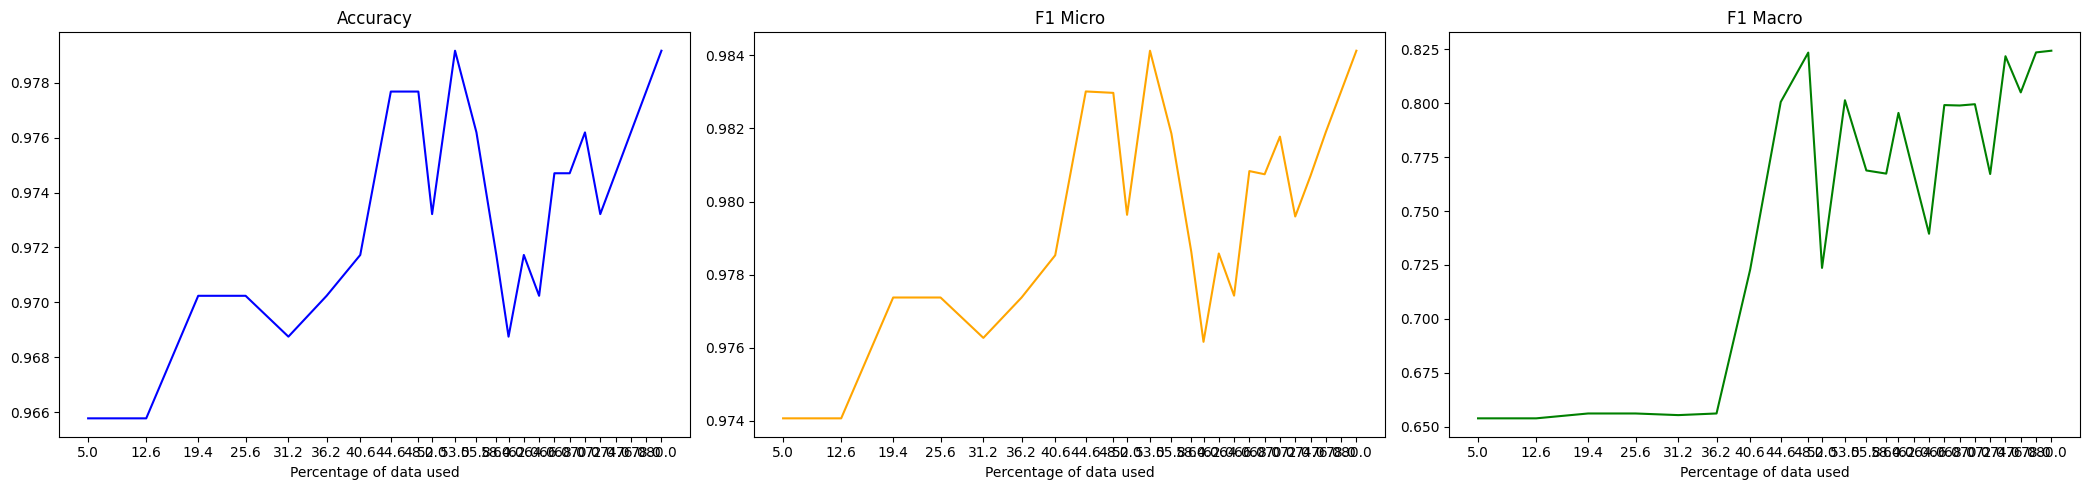

In [19]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6137, Accuracy: 0.9524, F1 Micro: 0.9635, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4556, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3444, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.248, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1986, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2051, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1674,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5551, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3372, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2775, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2038, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2446, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1678, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1593, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1916,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.472, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2235, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1884, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1597, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1491, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1365, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4504, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1965, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1674, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1352, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1542,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4213, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2116, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1466, Accuracy: 0.9628, F1 Micro: 0.9717, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1224, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.126, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.6527
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9598, F1 Micro: 0.9691, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1131, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1006, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2009, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1554, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.118, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1065, Accuracy: 0.9673, F1 Micro: 0.9748

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3611, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1479, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1413, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 8/10, Train Loss: 0.1261, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1188, Accuracy: 0.9688, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3524, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1966, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1766, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.129, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1215, Accuracy: 0.9747, F1 Micro: 0.9806, F1 Macro: 0.7242
Epoch 9/10, Train Loss: 0.0996, Accuracy: 0.9688, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3423, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1939, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.156, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1116, Accuracy: 0.9702, F1 Micro: 0.9771, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1014, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.344, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1788, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1271, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1265, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.6567
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9494, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.327, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1973, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9702, F1 Micro: 0.9771, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9643, F1 Micro: 0.9724

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1858, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1445, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9762, F1 Micro: 0.9818, F1 Macro: 0.725
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9717, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9747, F1 Micro: 0.9809, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.061

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3122, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.152, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1166, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0591,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3179, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1747, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1552, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9762, F1 Micro: 0.9818, F1 Macro: 0.7687
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9673, F1 Micro: 0.9754, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9777, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3143, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.7805
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9494, F1 Micro: 0.961, F1 Macro: 0.7394
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3037, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1294, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9792, F1 Micro: 0.9841, F1 Macro: 0.8013
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3244, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1952, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7669
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.7903
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9747, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3027, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7991
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7881
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7647
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.293, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.162, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1766, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9688, F1 Micro: 0.9759, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9717, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.296, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1532, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.7187
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7867
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.7945
Epoch 10/10, Train Loss: 0.0508, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.28, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1763, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1593, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6558
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9509, F1 Micro: 0.9617, F1 Macro: 0.6432
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9613, F1 Micro: 0.97, F1 Macro: 0.7158
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.7805
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2937, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9568, F1 Micro: 0.9665, F1 Macro: 0.7129
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 10/

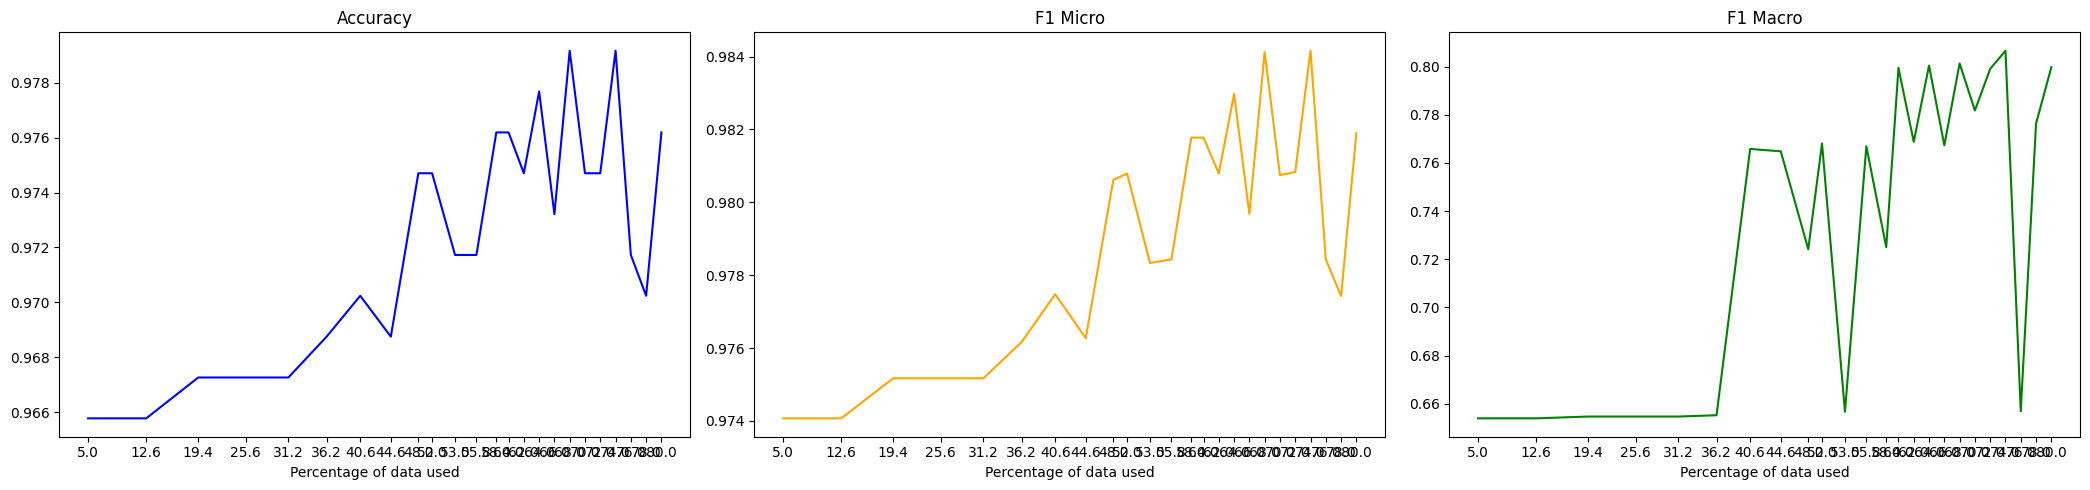

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6047, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.441, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3257, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2584, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.245, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1922, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1935, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5254, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.321, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2168, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2238, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1752, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1687, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4507, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2634, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2334, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2076, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2211, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1447,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4131, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2352, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1846, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1869, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1607, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1966, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1981, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1631, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1571, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1743, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3632, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2099, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1892, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1599, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1427, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1396

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3597, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2048, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1803, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1836, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1687, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1467, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7968
Epoch 9/10, Train Loss: 0.1184, Accuracy: 0.9643, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3418, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2144, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1788, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1995, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1217, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0953,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3104, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1851, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1699, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1172, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0807

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3286, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1879, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1509, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1376, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.102,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.318, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1681, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1377, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1078, Accuracy: 0.9688, F1 Micro: 0.9765, F1 Macro: 0.7873
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0892,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3082, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1881, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.16, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.124, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.9688, F1 Micro: 0.9764

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3097, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1658, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1353, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7973
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9658, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2956, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1905, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1288, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7982
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9732, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2832, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1804, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1536, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7968
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9658, F1 Micro: 0.9743, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9732, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1684, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1729, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9717, F1 Micro: 0.9787, F1 Macro: 0.8206
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7505
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7354
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2912, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1606, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1491, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9702, F1 Micro: 0.9776, F1 Macro: 0.7767
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9673, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2966, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1753, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9717, F1 Micro: 0.9787, F1 Macro: 0.8028
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7953
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7835
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2849, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1497, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7983
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.8227
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9628, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2798, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7877
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9673, F1 Micro: 0.9754, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7346
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1651, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9732, F1 Micro: 0.9798, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7395
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9628, F1 Micro: 0.9716, F1 Macro: 0.7547
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.282, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1699, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1577, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7968
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7506
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9628, F1 Micro: 0.9712, F1 Macro: 0.791
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.261, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1552, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7573
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7876
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2837, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1665, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9777, F1 Micro: 0.9831, F1 Macro: 0.8236
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.8199
Epoch 10/

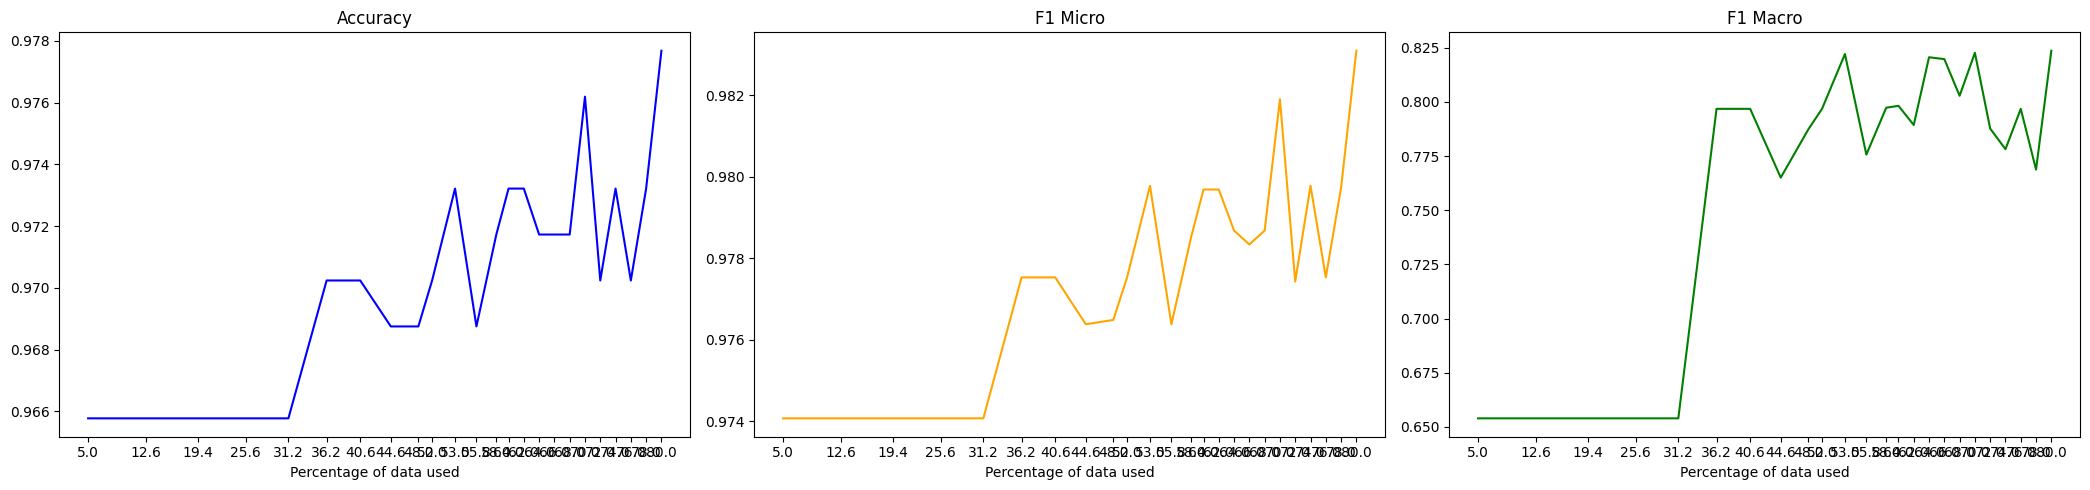

In [21]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6824, Accuracy: 0.933, F1 Micro: 0.9506, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4587, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3132, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2264, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2142, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.225, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5972, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2962, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.24, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2347, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1604, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1932, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1828, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1942, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2656, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2344, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2023, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1638, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1462, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4548, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2185, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1708, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1742, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1634, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1535,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4162, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2233, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.145, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.131, Accuracy: 0.9658, F1 Micro: 0.9741

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3936, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2052, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1834, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1484, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1299, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1317

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2073, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.191, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1639, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1579, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 9/10, Train Loss: 0.1266, Accuracy: 0.9673, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1515, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1453, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1301, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1085, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.6539
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3485, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1729, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1616, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.082

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3365, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1597, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1238, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.113

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3272, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1769, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.16, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1586, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1281, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 8/10, Train Loss: 0.1217, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.9702, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3188, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.135, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9688, F1 Micro: 0.976

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3197, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1659, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7219
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9613, F1 Micro: 0.9709, F1 Macro: 0.7386
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9658, F1 Micro: 0.9743, F1 Macro: 0.7403
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3083, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1513, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1405, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2953, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1638, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1485, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1548, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.9732, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.306, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1628, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7229
Epoch 8/10, Train Loss: 0.1033, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7286
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2968, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1498, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1696, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1525, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.133, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9688, F1 Micro: 0.9758, F1 Macro: 0.7638
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9702, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3025, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1499, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9688, F1 Micro: 0.9759, F1 Macro: 0.6548
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2974, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1609, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7634
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7802
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1583, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7079
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7651
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.7441
Epoch 10/10, Train Loss: 0.0551, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2939, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1808, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1559, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9568, F1 Micro: 0.9677, F1 Macro: 0.7195
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7552
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3094, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7961
Epoch 10/10, Train Loss: 0.0478, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2801, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1669, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1506, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9643, F1 Micro: 0.9731, F1 Macro: 0.7497
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2891, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0486, Accuracy: 

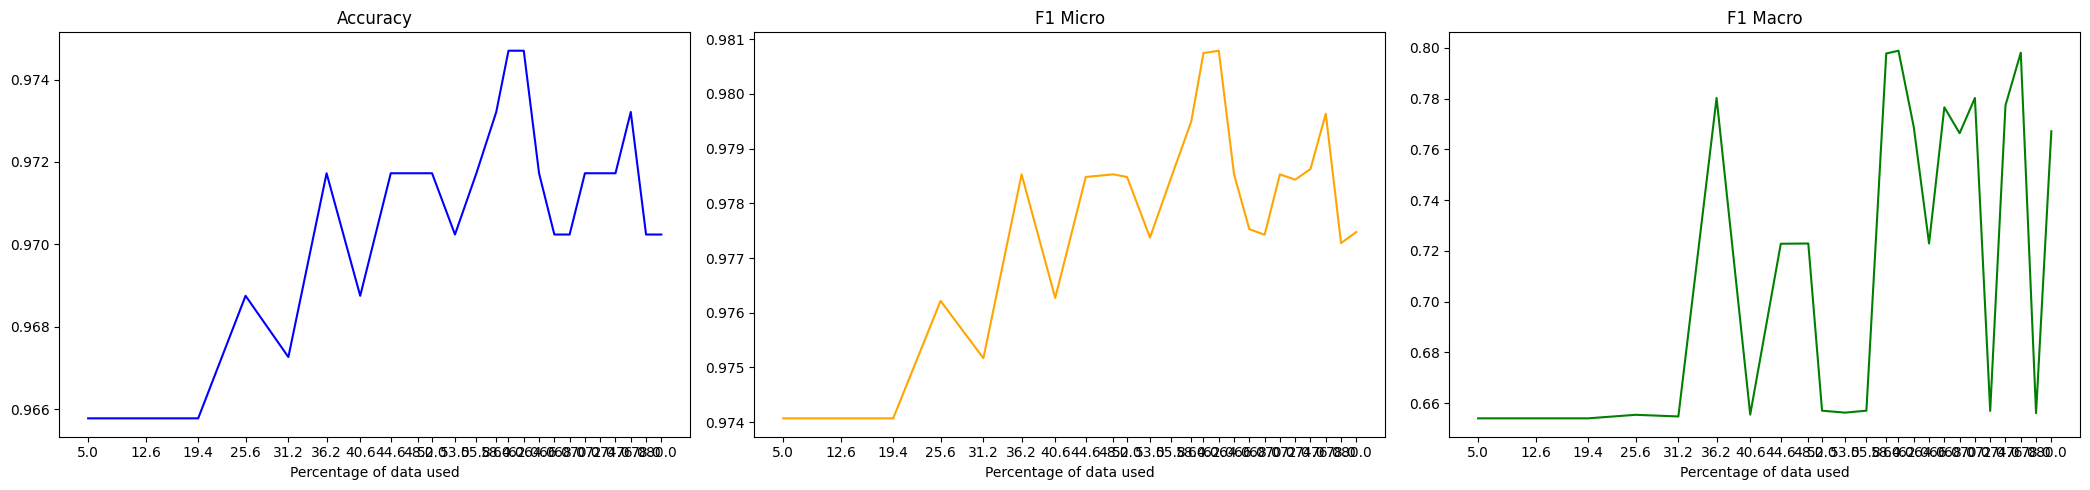

In [22]:
active_learning(seeds[4], 4)